# Combination of enrichment measurements
### ECP
Could not find original data sheets but a mass weighted average is given in https://www.mpi-hd.mpg.de/gerda/internal/GSTR/GSTR-13-009.pdf

In [1]:
using Measurements
ecp = measurement(87.42,0.36)
print("ECP value: $ecp")

ECP value: 87.42 ± 0.36

### NAA
Two measurements performed and combined, could not find original document but Riccardo had the values in his notebook

In [2]:
naa = measurement.([87.0,86.8],[1.1,1.1])
naa_mean = weightedmean(naa)
naa_score = stdscore(naa[1],naa[2])
print("NAA score: $naa_score\n")
print("NAA mean: $naa_mean")

NAA score: 0.12856486930664682
NAA mean: 86.9 ± 0.78

### ICPMS
Two measurements reported in https://www.mpi-hd.mpg.de/gerda/internal/GSTR/GSTR-06-018.pdf

In [3]:
icpms = measurement.([89.51,88.90],[0.02,0.02])
icpms_score = stdscore(icpms[1],icpms[2])
print("ICPMS score: $icpms_score\n")
print("Score scaled uncertainty: $(icpms_score*Measurements.uncertainty(icpms[1]))\n")

ICPMS score: 21.56675682618968
Score scaled uncertainty: 0.43133513652379357


Measurements highly incompatible with only statistical uncertainty but the GSTR states below the table:  
"The  total  error of result, evaluated for comparison with previuos   measurements, is <0.5 on 76Ge isotope percentage abundance."   
Using 0.5 instead of 0.02 as uncertainty the values are compatible within 1$\sigma$ and we can calculate their mean (score = 0.86).

In [4]:
icpms = measurement.([89.51,88.90],[0.5,0.5])
icpms_score = stdscore(icpms[1],icpms[2])
icpms_mean = weightedmean(icpms)
print("ICPMS score: $icpms_score\n")
print("ICPMS mean: $icpms_mean\n")

ICPMS score: 0.8626702730475871
ICPMS mean: 89.21 ± 0.35


However, the value given for ICPMS in GSTR-13-009 is 89.21$\pm$1.41 --> I suspect *2 instead of /2

In [14]:
enr = [ecp,naa_mean,icpms_mean]
n = 3
enr_value = Measurements.value.(enr)
enr_sigma = Measurements.uncertainty.(enr)

# arithmetic mean and sigma
enr_amean = sum(enr_value)/n
enr_amean_sigma = sqrt(sum( broadcast(*,enr_sigma,enr_sigma) ))/3
print("arithmetic mean: $enr_amean ± $enr_amean_sigma\n")

# compatibility NDF=n because we do not optimize by weighting ?
achi2_ndf = sum( broadcast(*,stdscore.(enr,enr_amean),stdscore.(enr,enr_amean)) )/n
print("compatibility χ²/NDF: $achi2_ndf\n")

# PDG recipe
as = sqrt(achi2_ndf)
enr_amean_sigma_scaled = enr_amean_sigma*as
print("Scale uncertainty according to PDF recipe by √(χ²/NDF): $enr_amean_sigma_scaled\n")

# Result
ares = measurement(enr_amean,enr_amean_sigma_scaled)
print("Result: $ares")

arithmetic mean: 87.84166666666665 ± 0.3090487196399802
compatibility χ²/NDF: 5.9023455861459135
Scale uncertainty according to PDF recipe by √(χ²/NDF): 0.7508259352836438
Result: 87.84 ± 0.75

In [27]:
# weighted mean and sigma
enr_wmean = weightedmean(enr)
print("weighted mean: $enr_wmean\n")

# compatibility NDF=n-1 because weighting is optmizing on one free parameter ?
enr_wmean_value = Measurements.value(enr_wmean)
wchi2_ndf = sum( broadcast(*,stdscore.(enr,enr_wmean_value),stdscore.(enr,enr_wmean_value)) )/(n-1)
print("compatibility χ²/NDF: $wchi2_ndf\n")

# PDG recipe
ws = sqrt(wchi2_ndf)
enr_wmean_sigma_scaled = Measurements.uncertainty(enr_wmean)*ws
print("Scale uncertainty according to PDF recipe by √(χ²/NDF): $enr_wmean_sigma_scaled\n")

# Result
wres = measurement(enr_wmean_value,enr_wmean_sigma_scaled)
print("Result: $wres")

weighted mean: 88.19 ± 0.24
compatibility χ²/NDF: 7.783550090170609
Scale uncertainty according to PDF recipe by √(χ²/NDF): 0.6694253903928382
Result: 88.19 ± 0.67

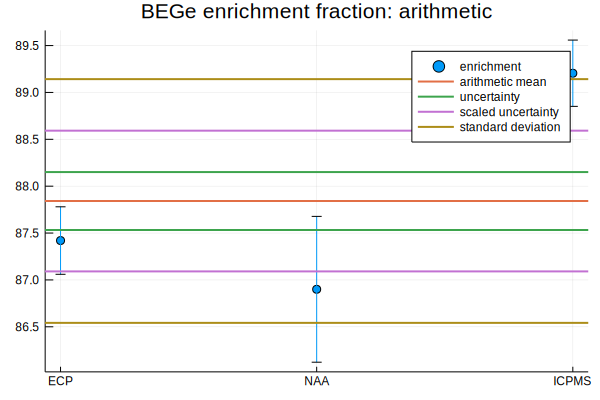

In [25]:
using Plots

# plot arithmetic mean
acentral = enr_amean
aupper   = enr_amean + enr_amean_sigma
alower   = enr_amean - enr_amean_sigma
aupper_s = enr_amean + enr_amean_sigma_scaled 
alower_s = enr_amean - enr_amean_sigma_scaled

names = ["ECP","NAA","ICPMS"]
scatter(names,enr,label = "enrichment",title="BEGe enrichment fraction: arithmetic")
plot!(Vector([acentral]),label="arithmetic mean",linewidth=2,linetype=[:hline])
plot!(Vector([aupper,alower]),label="uncertainty",linewidth=2,linetype=[:hline])
plot!(Vector([aupper_s,alower_s]),label="scaled uncertainty",linewidth=2,linetype=[:hline])
plot!(Vector([enr_amean-1.3,enr_amean+1.3]),label="standard deviation",linewidth=2,linetype=[:hline])

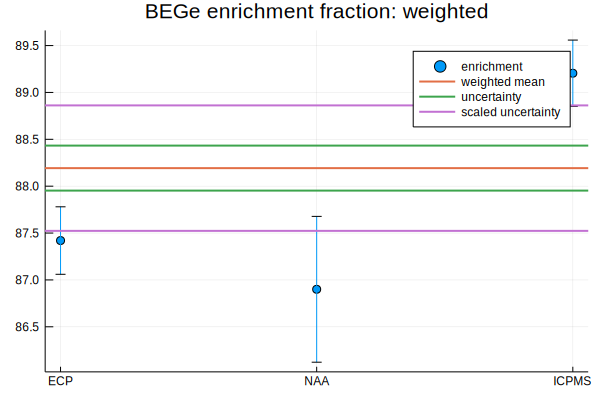

In [26]:
# plot weighted mean
enr_wmean_sigma = Measurements.uncertainty(enr_wmean)
wcentral = enr_wmean_value
wupper   = wcentral + enr_wmean_sigma
wlower   = wcentral - enr_wmean_sigma
wupper_s = wcentral + enr_wmean_sigma_scaled 
wlower_s = wcentral - enr_wmean_sigma_scaled

names = ["ECP","NAA","ICPMS"]
scatter(names,enr,label = "enrichment",title="BEGe enrichment fraction: weighted")
plot!(Vector([wcentral]),label="weighted mean",linewidth=2,linetype=[:hline])
plot!(Vector([wupper,wlower]),label="uncertainty",linewidth=2,linetype=[:hline])
plot!(Vector([wupper_s,wlower_s]),label="scaled uncertainty",linewidth=2,linetype=[:hline])

In [28]:
dist = broadcast(-,enr_amean,Measurements.value.(enr))
stddev = sqrt(sum(broadcast(*,dist,dist))/(n-1))

1.2089699472415947